In [1]:
import sys
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from keras.layers import Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from cosine_annealing import CosineAnnealingScheduler
from keras.layers import BatchNormalization
import pickle
from keras.regularizers import l2
from  scipy import ndimage
import numpy as np

2024-05-22 19:41:16.848590: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-22 19:41:16.882931: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-22 19:41:16.882966: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-22 19:41:16.883923: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-22 19:41:16.890360: I tensorflow/core/platform/cpu_feature_guar

#### Dataset


Load dataset + One-hot encoding + Normalization

In [2]:
def load_dataset(noise_ratio=0, sym=True):
    (trainX, trainY), (testX, testY) = cifar10.load_data()
    n_classes = 10

    if noise_ratio > 0:
        trainY_original = np.copy(trainY)
        if not sym:
            # Asymmetric noise
            source_class = [9, 2, 3, 5, 4]
            target_class = [1, 0, 5, 3, 7]
            
            for s, t in zip(source_class, target_class):
                cls_idx = np.where(trainY_original == s)[0]
                n_noisy = int(noise_ratio * cls_idx.shape[0] / 100)
                noisy_sample_index = np.random.choice(cls_idx, n_noisy, replace=False)
                trainY[noisy_sample_index] = t
        else:
            # Symetric noise
            n_samples = trainY.shape[0]
            n_noisy = int(noise_ratio * n_samples / 100)
            class_index = [np.where(trainY_original == i)[0] for i in range(n_classes)]
            class_noisy = int(n_noisy / n_classes)

            noisy_idx = []
            for d in range(n_classes):
                noisy_class_index = np.random.choice(class_index[d], class_noisy, replace=False)
                noisy_idx.extend(noisy_class_index)

            for i in noisy_idx:
                class_ind = trainY_original[i]
                other_class_list = list(range(n_classes))
                other_class_list.remove(class_ind)
                other_class = np.random.choice(other_class_list)
                trainY[i] = other_class
        
    # One-hot encoding
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
    # Normalize to [0,1]
    trainX = trainX.astype('float32') / 255.0
    testX = testX.astype('float32') / 255.0

    return trainX, trainY, testX, testY

#### Model

Imortant functions

In [3]:
def train(model, trainX, trainY, testX, testY):

	generator = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)

	train_data = generator.flow(trainX, trainY, batch_size=64)

	results = model.fit(train_data, epochs=100, validation_data=(testX, testY), verbose=1)

	return results

def evaluate(model, testX, testY):
    _, acc = model.evaluate(testX, testY, verbose=0)

    print(f"The model achieved a final accuracy of {acc*100:.2f}%")

def plot_results(history):
	plt.title('Cross Entropy Loss')
	plt.plot(history['loss'], color='blue', label='Training loss')
	plt.plot(history['val_loss'], color='orange', label='Validation/test loss')
	plt.legend()
	plt.show()

	plt.title('Classification Accuracy')
	plt.plot(history['accuracy'], color='blue', label='Training accuracy')
	plt.plot(history['val_accuracy'], color='orange', label='Validation/test accuracy')
	plt.legend()
	plt.show()

In [4]:
def save_model(filename, model):
    filename = './models/' + filename
    pickle.dump(model, open(filename, 'wb'))

def save_history(filename, history):
    filename = './history/' + filename
    pickle.dump(history, open(filename, 'wb'))

def load_model(filename):
    filename = './models/' + filename
    model = pickle.load(open(filename, 'rb'))
    return model

def load_history(filename):
    filename = './history/' + filename
    history = pickle.load(open(filename, 'rb'))
    return history

Baseline model

In [5]:
def dropout_model():
    # Create architecture
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    # model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    # model.add(Dropout(0.3))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    # model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    # model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))

    total_steps = int(trainX.shape[0]/64) * 100
    decay_steps = total_steps*0.8
    initial_learning_rate = 0.0001
    warmup_steps = 1000
    target_learning_rate = 0.1
    alpha = 0.001

    lr_warmup_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate, decay_steps, warmup_target=target_learning_rate,
        warmup_steps=warmup_steps,alpha = alpha
    )
    # Optimization method
    opt = SGD(learning_rate=lr_warmup_decayed_fn, momentum=0.9)

    # Compile model and choose loss type
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [6]:
trainX, trainY, testX, testY = load_dataset(noise_ratio=0, sym=True)

In [7]:
model = dropout_model()
results = train(model, trainX, trainY, testX, testY)

2024-05-22 19:41:20.210387: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2348] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 9.0. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.
2024-05-22 19:41:20.235592: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2348] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 9.0. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.
2024-05-22 19:41:20.481865: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1333 MB memory:  -> device: 0, name: NVIDIA H100 80GB HBM3 MIG 1g.10gb, pci bus id: 0000:df:00.0, compute capability: 9.0
2024-05-22 19:41:20.859075: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:225] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 9.0
2024-05-22 19:41:20.859099: W ext

Epoch 1/100


2024-05-22 19:41:22.329430: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-05-22 19:41:22.393627: W external/local_xla/xla/stream_executor/gpu/redzone_allocator.cc:322] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2024-05-22 19:41:22.707962: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-05-22 19:41:22.833264: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-05-22 19:41:22.833295: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilatio

782/782 [==============================] - 25s 26ms/step - loss: 1.4286 - accuracy: 0.4958 - val_loss: 4.0753 - val_accuracy: 0.2551
Epoch 2/100
782/782 [==============================] - 19s 24ms/step - loss: 0.9253 - accuracy: 0.6743 - val_loss: 1.0336 - val_accuracy: 0.6744
Epoch 3/100
782/782 [==============================] - 19s 24ms/step - loss: 0.7549 - accuracy: 0.7399 - val_loss: 0.7903 - val_accuracy: 0.7289
Epoch 4/100
782/782 [==============================] - 18s 23ms/step - loss: 0.6588 - accuracy: 0.7730 - val_loss: 0.8008 - val_accuracy: 0.7337
Epoch 5/100
782/782 [==============================] - 19s 24ms/step - loss: 0.5920 - accuracy: 0.7984 - val_loss: 0.7452 - val_accuracy: 0.7582
Epoch 6/100
782/782 [==============================] - 19s 24ms/step - loss: 0.5513 - accuracy: 0.8106 - val_loss: 0.6060 - val_accuracy: 0.7993
Epoch 7/100
782/782 [==============================] - 18s 23ms/step - loss: 0.5176 - accuracy: 0.8214 - val_loss: 0.5791 - val_accuracy: 0.80

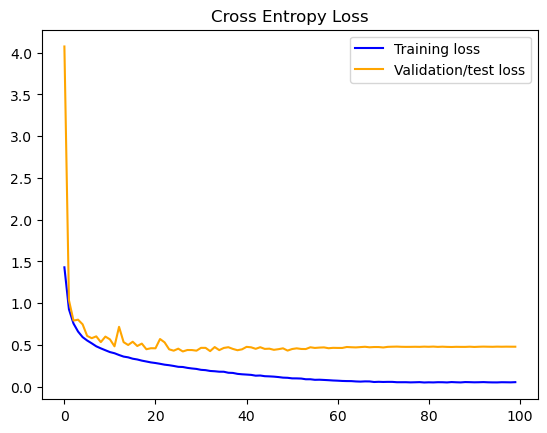

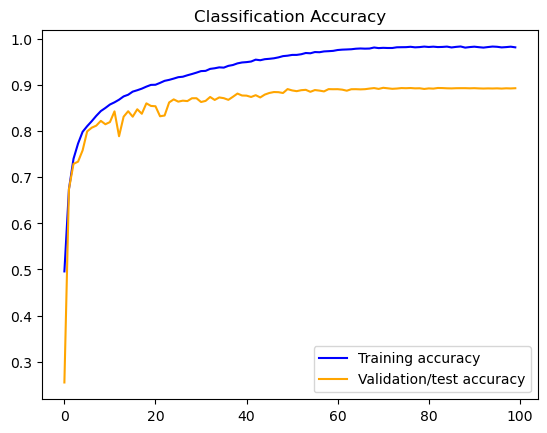

The model achieved a final accuracy of 89.29%


In [8]:
plot_results(results.history)
evaluate(model, testX, testY)

In [9]:
save_model('CE_no_noise', model)
save_history('CE_no_noise', results.history)